In [1]:
import pandas as pd
import numpy as np
import wrds

In [2]:
from datetime import datetime
from scipy.stats import skew, kurtosis
import time

In [3]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [4]:
# Establish connection to WRDS
db = wrds.Connection()

Enter your WRDS username [ec2-user]: ly229
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## Ownership data of Fund Holdings(index, active, and institutional)

### index ownership: revised filter(comphrensive condition)

#### testing filter

In [ ]:
index_keywords = ['INDEX', 'ETF', 'S&P', 'NASDAQ', 'MSCI', 'FTSE', 'TSX', 'PASSIVE', '500', '2000']
tnf_22q1['group'] = tnf_22q1['fundname'].apply(
    lambda x: 'Index' if (any(keyword in str(x) for keyword in index_keywords) 
                          and not str(x).startswith('NASDAQ'))
                          or ('Russell' in str(x) and not str(x).startswith('Russell')) 
                          or 'Russell 2000' in str(x)
                          or 'DOW ' in str(x)  # Contains 'DOW ' (with space)
                          or 'DOW30' in str(x)
                          or str(x).endswith('IND') else 'Active'
)

In [11]:
start_time_ins = time.time()

test_query_22q1 = """
    WITH Ownership AS (
        SELECT
            cusip, 
            fdate AS date,
            shares / 1000000 / shrout1 AS ownership,
            CASE
                WHEN fundname LIKE '%%IND' OR fundname LIKE '%%INDEX%%' OR fundname LIKE '%%ETF%%' OR 
                     fundname LIKE '%%S&P%%' OR fundname LIKE '%%NASDAQ%%' OR fundname LIKE '%%MSCI%%' OR 
                     fundname LIKE '%%FTSE%%' OR fundname LIKE '%%TSX%%' OR fundname LIKE '%%PASSIVE%%' OR
                     fundname LIKE '%%500%%' OR fundname LIKE '%%2000%%' OR 
                     fundname LIKE 'NASDAQ%%' OR
                     (fundname LIKE '%%Russell%%' AND fundname NOT LIKE 'Russell%%') OR
                     fundname LIKE '%%Russell 2000%%' OR
                     fundname LIKE '%%DOW %%' OR fundname LIKE '%%DOW30%%'
                     
                THEN 'Index Fund'
                ELSE 'Active Fund'
            END AS fund_type
        
        FROM 
            tfn.s12
        
        WHERE 
            fdate BETWEEN '2022-01-01' AND '2022-03-31'
            AND country = 'UNITED STATES'
            AND shrout1 > 10
    )
    SELECT 
        cusip,
        date,
        SUM(CASE WHEN fund_type = 'Index Fund' THEN ownership ELSE 0 END) AS index_own,
        SUM(CASE WHEN fund_type = 'Active Fund' THEN ownership ELSE 0 END) AS active_own
    FROM 
        Ownership
    GROUP BY 
        cusip, date
    ORDER BY 
        cusip, date
    
"""

try:
    test_result_22q1 = db.raw_sql(test_query_22q1)
    print(test_result_22q1)
except Exception as e:
    print("Error executing test query:", e)
    
end_time_ins = time.time()
execution_time_ins = end_time_ins - start_time_ins

print(f"Execution time for test ownership query: {execution_time_ins:.4f} seconds")

          cusip        date  index_own  active_own
0      00025510  2022-03-31   0.001300    0.044220
1      00032Q10  2022-03-31   0.046841    0.045099
2      00036020  2022-03-31   0.170619    0.272480
3      00036110  2022-03-31   0.255729    0.331415
4      00037520  2022-03-31   0.000019    0.010462
...         ...         ...        ...         ...
25111  Y9T91Q10  2022-03-31   0.009512    0.018490
25112  Y9T92M10  2022-03-31   0.000000    0.000121
25113  Y9T94Z10  2022-03-31   0.000000    0.000521
25114  Y9T95Z11  2022-03-31   0.000002    0.006444
25115  Y9T9HH10  2022-03-31   0.000000    0.009010

[25116 rows x 4 columns]
Execution time for test ownership query: 1.3266 seconds


In [12]:
count_zero = (test_result_22q1['index_own'] == 0).sum()
print(count_zero)

8497


### Obtain the combined data for active and index ownership

In [15]:
file_name = "tnf_own_combined.csv"

start_year = 1993
current_year = datetime.now().year

for year in range(start_year, current_year + 1):
    
    print(f"Downloading data for the year {year}...")
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    query = f"""
    WITH Ownership AS (
        SELECT
            cusip, 
            fdate AS date,
            shares / 1000000 / shrout1 AS ownership,
            CASE
                WHEN fundname LIKE '%%IND' OR fundname LIKE '%%INDEX%%' OR fundname LIKE '%%ETF%%' OR 
                     fundname LIKE '%%S&P%%' OR fundname LIKE '%%NASDAQ%%' OR fundname LIKE '%%MSCI%%' OR 
                     fundname LIKE '%%FTSE%%' OR fundname LIKE '%%TSX%%' OR fundname LIKE '%%PASSIVE%%' OR
                     fundname LIKE '%%500%%' OR fundname LIKE '%%2000%%' OR 
                     fundname LIKE 'NASDAQ%%' OR
                     (fundname LIKE '%%Russell%%' AND fundname NOT LIKE 'Russell%%') OR
                     fundname LIKE '%%Russell 2000%%' OR
                     fundname LIKE '%%DOW %%' OR fundname LIKE '%%DOW30%%'
                     
                THEN 'Index Fund'
                ELSE 'Active Fund'
            END AS fund_type
        
        FROM 
            tfn.s12
        
        WHERE 
            fdate BETWEEN '{start_date}' AND '{end_date}'
            AND country = 'UNITED STATES'
            AND shrout1 > 10
            AND shares/1000000/shrout1 >= 0.00001
        )
        SELECT 
            cusip,
            date,
            SUM(CASE WHEN fund_type = 'Index Fund' THEN ownership ELSE 0 END) AS index_own,
            SUM(CASE WHEN fund_type = 'Active Fund' THEN ownership ELSE 0 END) AS active_own
        FROM 
            Ownership
        GROUP BY 
            cusip, date
        ORDER BY 
            cusip, date;
    """
    
    # Fetch data for the current year
    year_data = db.raw_sql(query)
    
    # Append the data to the CSV file
    if year == start_year:
        # Write with header if it's the first year
        year_data.to_csv(file_name, mode='w', header=True, index=False)
    else:
        # Append without header if it's not the first year
        year_data.to_csv(file_name, mode='a', header=False, index=False)
    
    print(f"Data for year {year} appended to '{file_name}'")

Data for year 1993 appended to 'tnf_own_combined.csv'
Data for year 1994 appended to 'tnf_own_combined.csv'
Data for year 1995 appended to 'tnf_own_combined.csv'
Data for year 1996 appended to 'tnf_own_combined.csv'
Data for year 1997 appended to 'tnf_own_combined.csv'
Data for year 1998 appended to 'tnf_own_combined.csv'
Data for year 1999 appended to 'tnf_own_combined.csv'
Data for year 2000 appended to 'tnf_own_combined.csv'
Data for year 2001 appended to 'tnf_own_combined.csv'
Data for year 2002 appended to 'tnf_own_combined.csv'
Data for year 2003 appended to 'tnf_own_combined.csv'
Data for year 2004 appended to 'tnf_own_combined.csv'
Data for year 2005 appended to 'tnf_own_combined.csv'
Data for year 2006 appended to 'tnf_own_combined.csv'
Data for year 2007 appended to 'tnf_own_combined.csv'
Data for year 2008 appended to 'tnf_own_combined.csv'
Data for year 2009 appended to 'tnf_own_combined.csv'
Data for year 2010 appended to 'tnf_own_combined.csv'
Data for year 2011 appended 

### Grasp Institutional Data

#### - filter out incorrect data entry(>100%) and non-meaningful entry(<0)

In [ ]:
file_name = "tnf_data_ins.csv"

start_year = 1993
current_year = datetime.now().year

for year in range(start_year, current_year + 1):
    
    print(f"Downloading data for the year {year}...")
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    query = f"""
        SELECT  
        cusip, fdate AS date,  
        sum(shares/1000000/shrout1) AS ins_own
        
        FROM tfn.s34
        
        WHERE fdate BETWEEN '{start_date}' AND '{end_date}'
        AND country = 'UNITED STATES'
        AND shrout1 > 0
        AND shares/1000000/shrout1 <= 1
        AND shares/1000000/shrout1 >= 0.00001

        GROUP BY 
            cusip, fdate
        ORDER BY 
            cusip, fdate;
    """
    
    # Fetch data for the current year
    year_data = db.raw_sql(query)
    
    # Append the data to the CSV file
    if year == start_year:
        # Write with header if it's the first year
        year_data.to_csv(file_name, mode='w', header=True, index=False)
    else:
        # Append without header if it's not the first year
        year_data.to_csv(file_name, mode='a', header=False, index=False)
    
    print(f"Data for year {year} appended to '{file_name}'")

### Retrieve and check ative, index and instit data

In [3]:
df_ins= pd.read_csv('tnf_data_ins.csv')

In [16]:
df_own= pd.read_csv('tnf_own_combined.csv')

In [4]:
def count_non_zero(cusip_series, ownership_series):
   return len(cusip_series[ownership_series != 0].unique())

#### 1.) data summary for index and active ownership

In [17]:
df_own['date'] = pd.to_datetime(df_own['date'])

# Step 3: Extract year
df_own['year'] = df_own['date'].dt.year

# Group by year and calculate summary statistics
summary_own = df_own.groupby('year').agg(
    average_index_ownership=('index_own', 'mean'),
    median_index_ownership=('index_own', 'median'),
    average_active_ownership=('active_own', 'mean'),
    median_active_ownership=('active_own', 'median'),
     index_stock_count=('cusip', lambda x: count_non_zero(x, df_own.loc[x.index, 'index_own'])),
    active_stock_count=('cusip', lambda x: count_non_zero(x, df_own.loc[x.index, 'active_own']))  # Count unique stocks
).reset_index()

# Display the summarized DataFrame
print(summary_own)

    year  average_index_ownership  median_index_ownership  \
0   1999                 0.003341                0.000056   
1   2000                 0.003437                0.000055   
2   2001                 0.004877                0.000210   
3   2002                 0.006915                0.000445   
4   2003                 0.008487                0.001812   
5   2004                 0.012610                0.002715   
6   2005                 0.012697                0.002685   
7   2006                 0.011702                0.001525   
8   2007                 0.012609                0.000955   
9   2008                 0.014887                0.000800   
10  2009                 0.019041                0.001069   
11  2010                 0.022136                0.001324   
12  2011                 0.023012                0.000994   
13  2012                 0.025752                0.003563   
14  2013                 0.026271                0.002639   
15  2014                

In [8]:
df_ins['date'] = pd.to_datetime(df_ins['date'])

# Extract year
df_ins['year'] = df_ins['date'].dt.year

# Step 4: Group by year and calculate summary statistics
summary_inst= df_ins.groupby('year').agg(
    average_instit_ownership=('ins_own', 'mean'),
    median_instit_ownership=('ins_own', 'median'),
    min_instit_ownership=('ins_own', 'min'),
    max_instit_ownership=('ins_own', 'max'),
    q25_instit_ownership=('ins_own', lambda x: x.quantile(0.25)),
    q75_instit_ownership=('ins_own', lambda x: x.quantile(0.75)),
    q95_instit_ownership=('ins_own', lambda x: x.quantile(0.95)),
    q98_instit_ownership=('ins_own', lambda x: x.quantile(0.98)),
    skewness_instit_ownership=('ins_own', lambda x: skew(x, nan_policy='omit')),
    kurtosis_instit_ownership=('ins_own', lambda x: kurtosis(x, nan_policy='omit')),
    instit_stock_count=('cusip', lambda x: count_non_zero(x, df_ins.loc[x.index, 'ins_own']))  # Count unique stocks
).reset_index()

# Display the summarized DataFrame
print(summary_inst)

    year  average_instit_ownership  median_instit_ownership  \
0   1999                  0.238187                 0.142656   
1   2000                  0.221897                 0.117480   
2   2001                  0.236479                 0.119187   
3   2002                  0.249787                 0.118629   
4   2003                  0.270349                 0.138881   
5   2004                  0.287599                 0.148776   
6   2005                  0.304048                 0.167363   
7   2006                  0.303505                 0.165042   
8   2007                  0.319727                 0.182922   
9   2008                  0.315660                 0.191456   
10  2009                  0.294768                 0.181383   
11  2010                  0.319254                 0.196134   
12  2011                  0.296731                 0.164777   
13  2012                  0.308294                 0.191818   
14  2013                  0.311460                 0.19

### Plot Data Summary and Compare

#### - 1) plot average ownership comparison

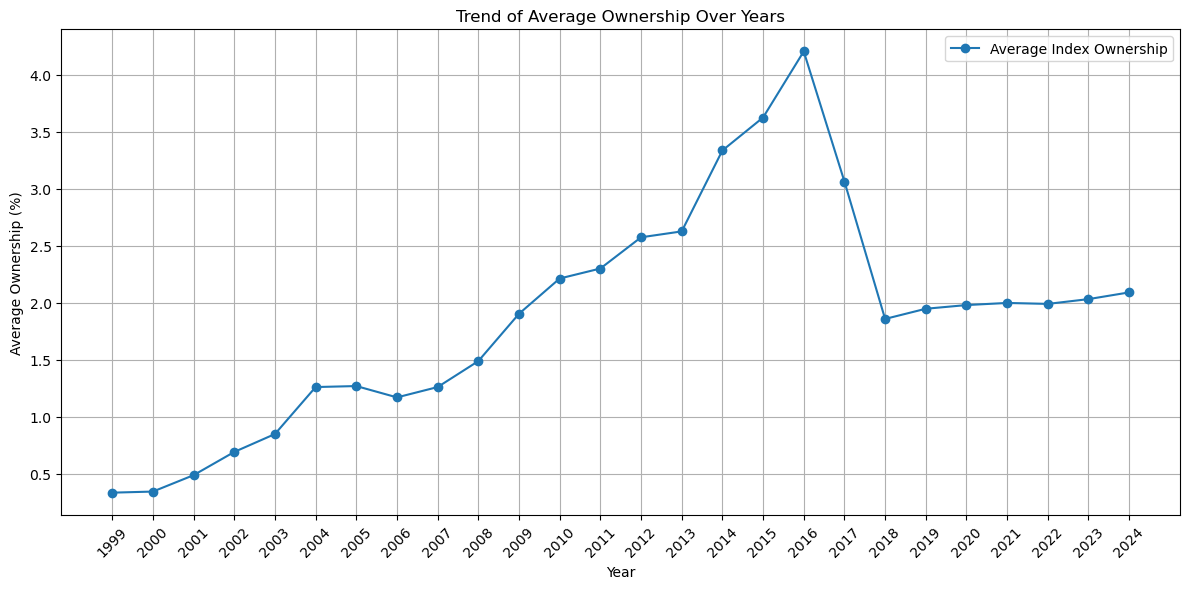

In [19]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot each ownership type
plt.plot(summary_own['year'], summary_own['average_index_ownership']*100, label='Average Index Ownership', marker='o')
#plt.plot(summary_own['year'], summary_own['average_active_ownership']*100, label='Average Active Ownership', marker='o')
#plt.plot(summary_own['year'], summary_inst['average_instit_ownership']*100, label='Average Institutional Ownership', marker='o')

# Adding labels and title
plt.title('Trend of Average Ownership Over Years')
plt.xlabel('Year')
plt.ylabel('Average Ownership (%)')
plt.xticks(summary_own['year'], rotation=45)  # Rotate x-ticks for better visibility
plt.legend()
plt.grid()

# Save the plot to a file
plt.tight_layout()
plt.savefig('average_ownership_trend.png', dpi=300)  # Save as PNG with high resolution
plt.show()

#### - 2) plot average ownership comparison

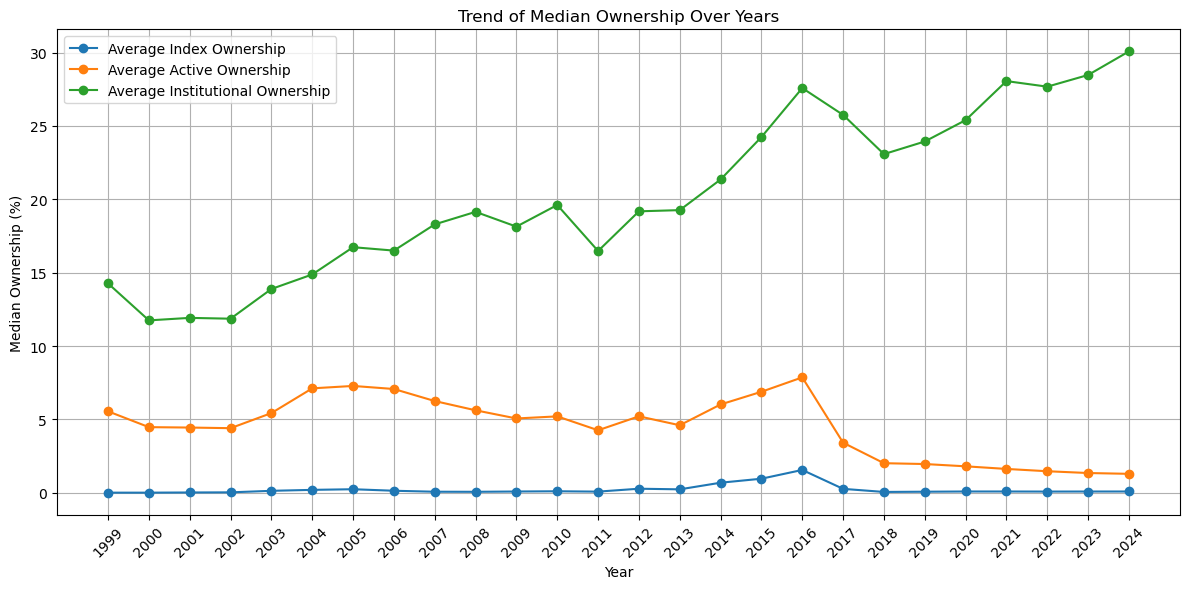

In [12]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot each ownership type
plt.plot(summary_own['year'], summary_own['median_index_ownership']*100, label='Average Index Ownership', marker='o')
plt.plot(summary_own['year'], summary_own['median_active_ownership']*100, label='Average Active Ownership', marker='o')
plt.plot(summary_own['year'], summary_inst['median_instit_ownership']*100, label='Average Institutional Ownership', marker='o')

# Adding labels and title
plt.title('Trend of Median Ownership Over Years')
plt.xlabel('Year')
plt.ylabel('Median Ownership (%)')
plt.xticks(summary_own['year'], rotation=45)  # Rotate x-ticks for better visibility
plt.legend()
plt.grid()

# Save the plot to a file
plt.tight_layout()
plt.savefig('median_ownership_trend.png', dpi=300)  # Save as PNG with high resolution
plt.show()